<a href="https://colab.research.google.com/github/Su5rm/geekle-2021-april-9/blob/main/Time_Series_Forecast_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All code adapted from https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# load dataset
data = pd.read_csv('AirPassengers.csv')
print(data.head())
print(' \n Data Types:')
print(data.dtypes)

     Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121
 
 Data Types:
Month          object
#Passengers     int64
dtype: object


In [ ]:
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [ ]:
# set month as index
ts = data.set_index('Month')
ts.head(10)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [ ]:
# check that we can slice data by date
ts.loc['1949-01-01']

#Passengers    112
Name: 1949-01-01 00:00:00, dtype: int64

In [ ]:
# check that we can slice data by range
ts.loc[:'1949-05-01']

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
# check that we can slice data by year
ts.loc['1949']

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


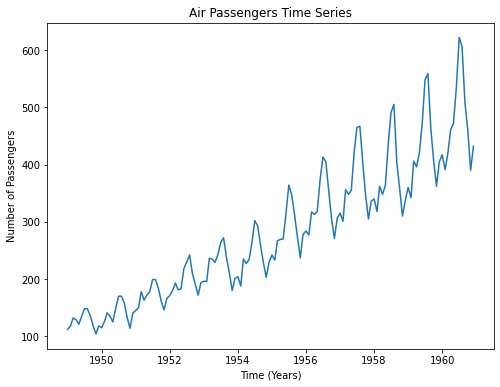

In [ ]:
# Check for stationarity of data by visualising data
fig = plt.figure(figsize=(8,6))
plt.plot(ts)
plt.title('Air Passengers Time Series')
plt.xlabel('Time (Years)')
plt.ylabel('Number of Passengers')
plt.show()

In [ ]:
# Check for Stationarity of time series by plotting rolling series and Dickey-Fuller Test
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

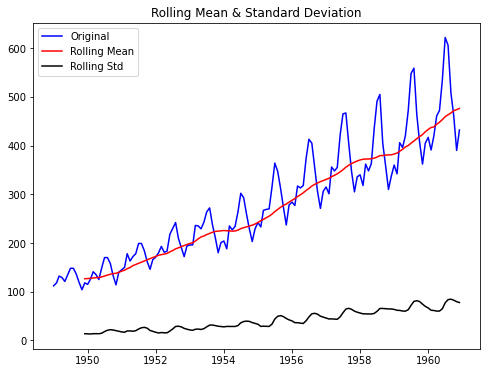

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
fig = plt.figure(figsize=(8,6))
test_stationarity(ts)

Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values.

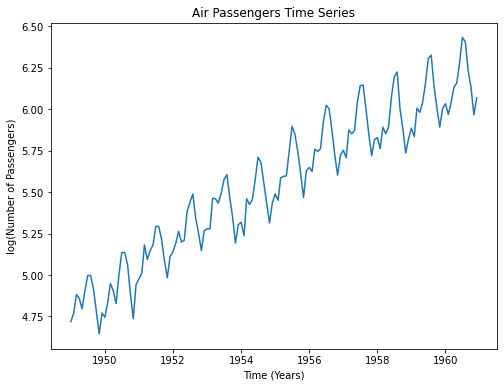

In [ ]:
# To move this time series towards satationarity we will first log transform the data
ts_log = np.log(ts)
fig = plt.figure(figsize=(8,6))
plt.plot(ts_log)
plt.title('Air Passengers Time Series')
plt.xlabel('Time (Years)')
plt.ylabel('log(Number of Passengers)')
plt.show()

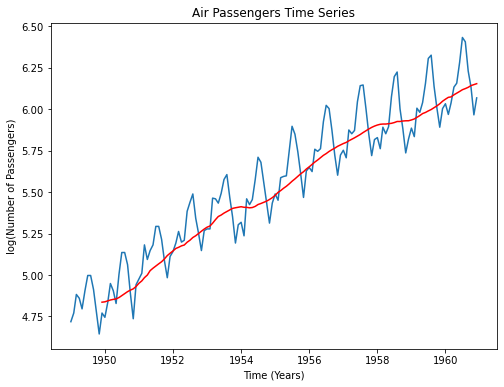

In [ ]:
# In this instance smoothing will be used on the data (we can also use aggregation or regression models)
moving_avg = ts_log.rolling(12).mean()
fig = plt.figure(figsize=(8,6))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
plt.title('Air Passengers Time Series')
plt.xlabel('Time (Years)')
plt.ylabel('log(Number of Passengers)')
plt.show()

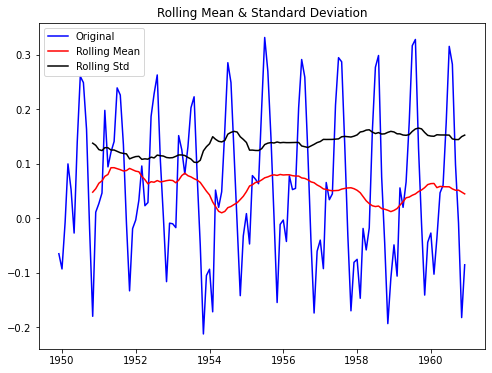

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [ ]:
# subtract the rolling mean from the original series and test stationarity
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
fig = plt.figure(figsize=(8,6))
test_stationarity(ts_log_moving_avg_diff)

This looks like a much better series. The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

However, a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. So we take a ‘weighted moving average’ where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.

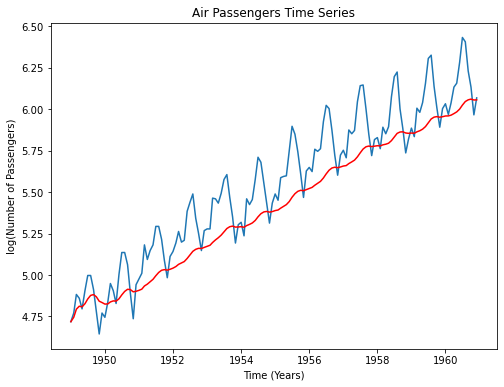

In [ ]:
# calculating and plotting the weighted moving average
expwighted_avg = ts_log.ewm(halflife=12).mean()
fig = plt.figure(figsize=(8,6))
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
plt.title('Air Passengers Time Series')
plt.xlabel('Time (Years)')
plt.ylabel('log(Number of Passengers)')
plt.show()

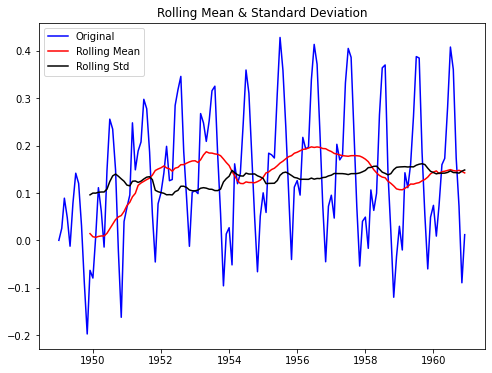

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [ ]:
# test for stationarity
ts_log_ewma_diff = ts_log - expwighted_avg
fig = plt.figure(figsize=(8,6))
test_stationarity(ts_log_ewma_diff)

This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value, which is better than the previous case. Note that in this case there will be no missing values as all values from starting are given weights. So it’ll work even with no previous values.

The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. Lets discuss two ways of removing trend and seasonality:

    Differencing – taking the differece with a particular time lag
    
    Decomposition – modeling both trend and seasonality and removing them from the model.

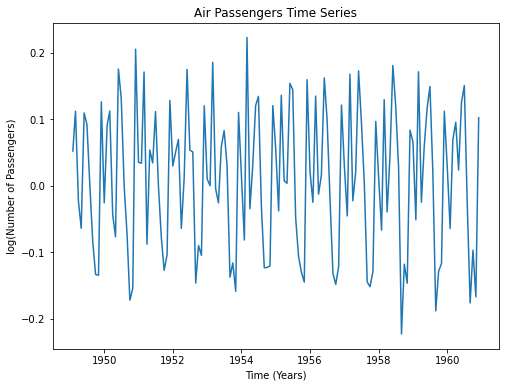

In [ ]:
# First we carry out differencing
ts_log_diff = ts_log - ts_log.shift()
fig = plt.figure(figsize=(8,6))
plt.plot(ts_log_diff)
plt.title('Air Passengers Time Series')
plt.xlabel('Time (Years)')
plt.ylabel('log(Number of Passengers)')
plt.show()

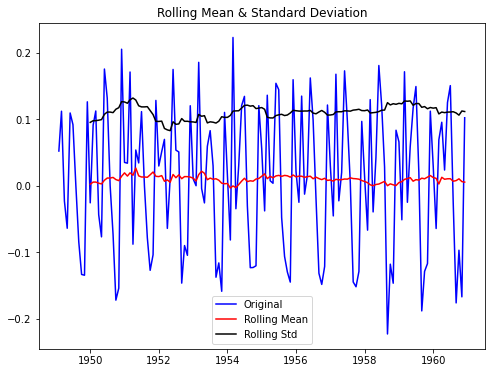

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [ ]:
# Test stationarity
ts_log_diff.dropna(inplace=True)
fig = plt.figure(figsize=(8,6))
test_stationarity(ts_log_diff)

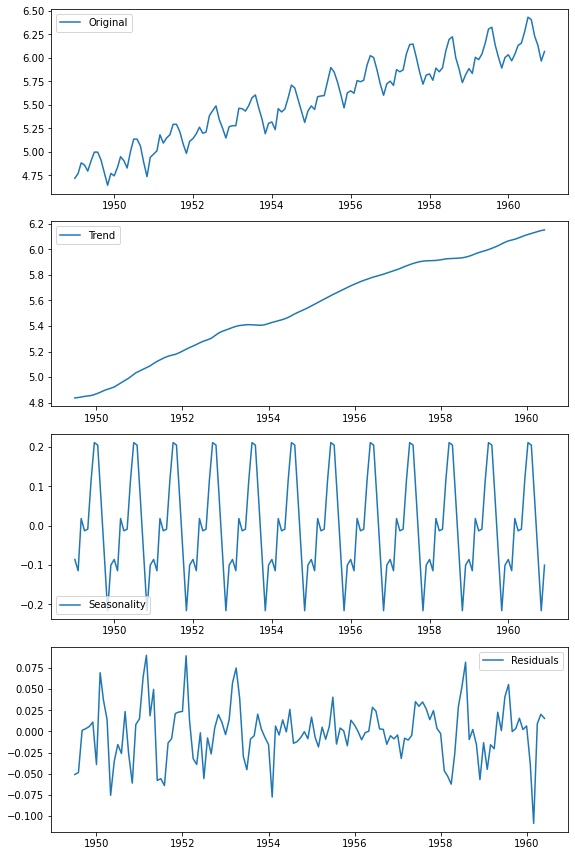

In [ ]:
# decomposition
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(8,12))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

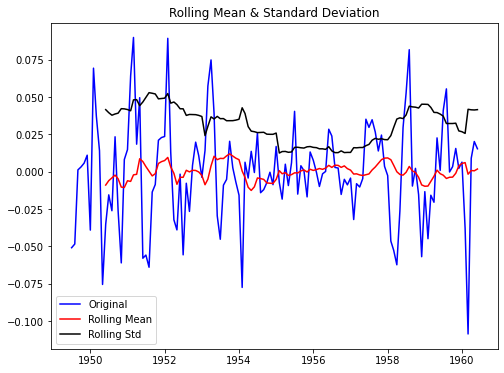

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [ ]:
# Check stationarity of residuals
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
fig = plt.figure(figsize=(8,6))
test_stationarity(ts_log_decompose)

The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary. You can try advanced decomposition techniques as well which can generate better results.

### Forecasting a Time Series

We saw different techniques and all of them worked reasonably well for making the TS stationary. Lets make model on the TS after differencing as it is a very popular technique. Also, its relatively easier to add noise and seasonality back into predicted residuals in this case. Having performed the trend and seasonality estimation techniques, there can be two situations:

    A strictly stationary series with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
    A series with significant dependence among values. In this case we need to use some statistical models like ARIMA to forecast the data.

Let me give you a brief introduction to ARIMA. I won’t go into the technical details but you should understand these concepts in detail if you wish to apply them more effectively. ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

    Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
    Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
    Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

An importance concern here is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers. Lets discuss them first.

    Autocorrelation Function (ACF): It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
    Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [ ]:
#ACF and PACF plots
lag_acf = acf(ts_log_diff, nlags=20, fft=False)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

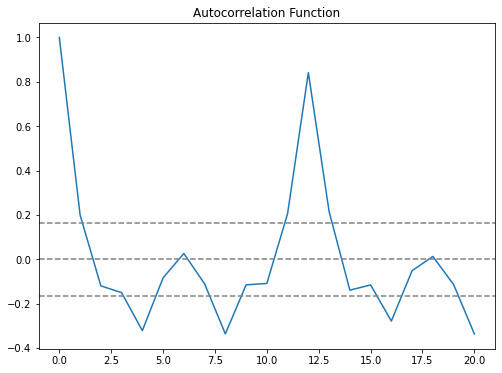

In [ ]:
#Plot ACF: 
plt.figure(figsize=(18,6))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

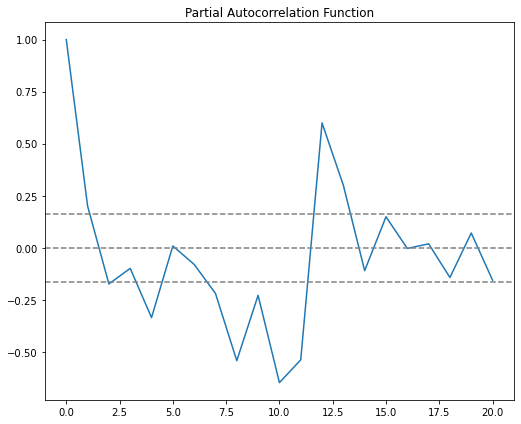

In [ ]:
#Plot PACF:
plt.figure(figsize=(14,6))
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Users\susan\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


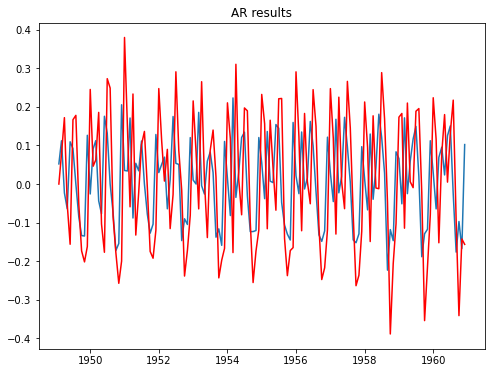

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  143
Model:                 ARIMA(1, 2, 0)   Log Likelihood                  40.233
Date:                Sun, 25 Apr 2021   AIC                            -76.465
Time:                        18:34:45   BIC                            -70.568
Sample:                    02-01-1949   HQIC                           -74.069
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5423      0.080     -6.776      0.000      -0.699      -0.385
sigma2         0.0330      0.006      5.807      0.000       0.022       0.044
Ljung-Box (L1) (Q):                  10.76   Jarque-

In [ ]:
# AR Model
model = ARIMA(ts_log_diff, order=(1, 2, 0), freq='MS')    
results_AR = model.fit()
fig = plt.figure(figsize=(8,6))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('AR results')
plt.show()
print(results_AR.summary())

C:\Users\susan\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\susan\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


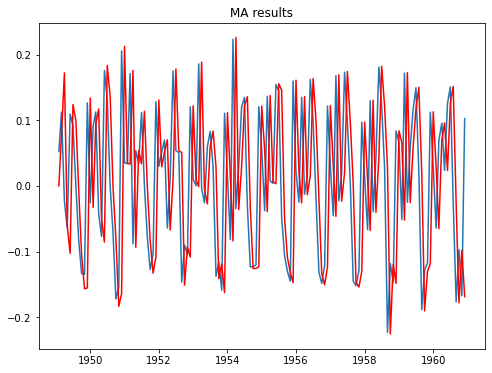

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  143
Model:                 ARIMA(0, 2, 1)   Log Likelihood                  79.794
Date:                Sun, 25 Apr 2021   AIC                           -155.587
Time:                        18:34:46   BIC                           -149.690
Sample:                    02-01-1949   HQIC                          -153.191
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000     82.068     -0.012      0.990    -161.850     159.850
sigma2         0.0182      1.496      0.012      0.990      -2.913       2.949
Ljung-Box (L1) (Q):                  12.04   Jarque-

In [ ]:
# MA Model
model = ARIMA(ts_log_diff, order=(0, 2, 1), freq='MS')    
results_AR = model.fit()
fig = plt.figure(figsize=(8,6))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('MA results')
plt.show()
print(results_AR.summary())

C:\Users\susan\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


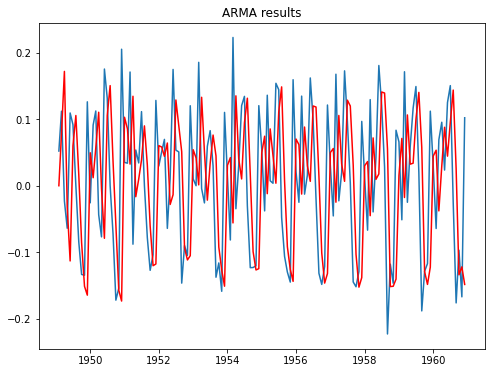

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  143
Model:                 ARIMA(1, 2, 1)   Log Likelihood                  86.001
Date:                Sun, 25 Apr 2021   AIC                           -166.002
Time:                        18:34:46   BIC                           -157.156
Sample:                    02-01-1949   HQIC                          -162.408
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2944      0.124     -2.377      0.017      -0.537      -0.052
ma.L1         -1.0000    236.586     -0.004      0.997    -464.700     462.700
sigma2         0.0166      3.931      0.004      0.9

In [ ]:
# Combined ARMA results

model = ARIMA(ts_log_diff, order=(1, 2, 1), freq='MS')    
results_AR = model.fit()
fig = plt.figure(figsize=(8,6))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('ARMA results')
plt.show()
print(results_AR.summary())

In [ ]:
# Taking it back to original scale
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.000000
1949-03-01    0.078279
1949-04-01    0.172049
1949-05-01   -0.031866
1949-06-01   -0.113230
dtype: float64


In [ ]:
# culmulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.000000
1949-03-01    0.078279
1949-04-01    0.250327
1949-05-01    0.218462
1949-06-01    0.105232
dtype: float64


In [ ]:
# Check if correct
predictions_ARIMA_log = pd.Series(ts_log.iloc[0,0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.796778
1949-04-01    4.968826
1949-05-01    4.936961
dtype: float64

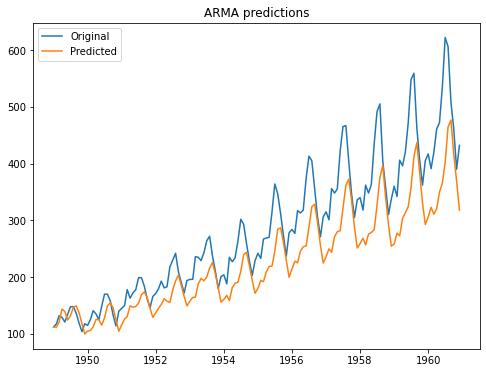

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
fig = plt.figure(figsize=(8,6))
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.legend(['Original','Predicted'])
plt.title('ARMA predictions')
plt.show()

In [ ]:
# Calculate the mean squared error
diff = ts['#Passengers'].astype('float64')-predictions_ARIMA
mean_squared_error = np.power(diff, 2).mean()
print('The mean squared error is: ', mean_squared_error)

The mean squared error is:  5085.882863204955
